
# Exploring GAN input space

Using the pythia data, we define a simple GAN model and explore the effect of pre-processing the data on the model

- [x] GAN model
- [x] Figure of Merit
- [x] Scalers
- [ ] Physics inspired conditioning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import kl_div

In [2]:
# load data

e = np.loadtxt("./PythiaMomenta.csv",delimiter=",")
e_split = np.split(e,len(e)/8)
events = np.stack(e_split)
print(events.shape)

(1000000, 8, 4)


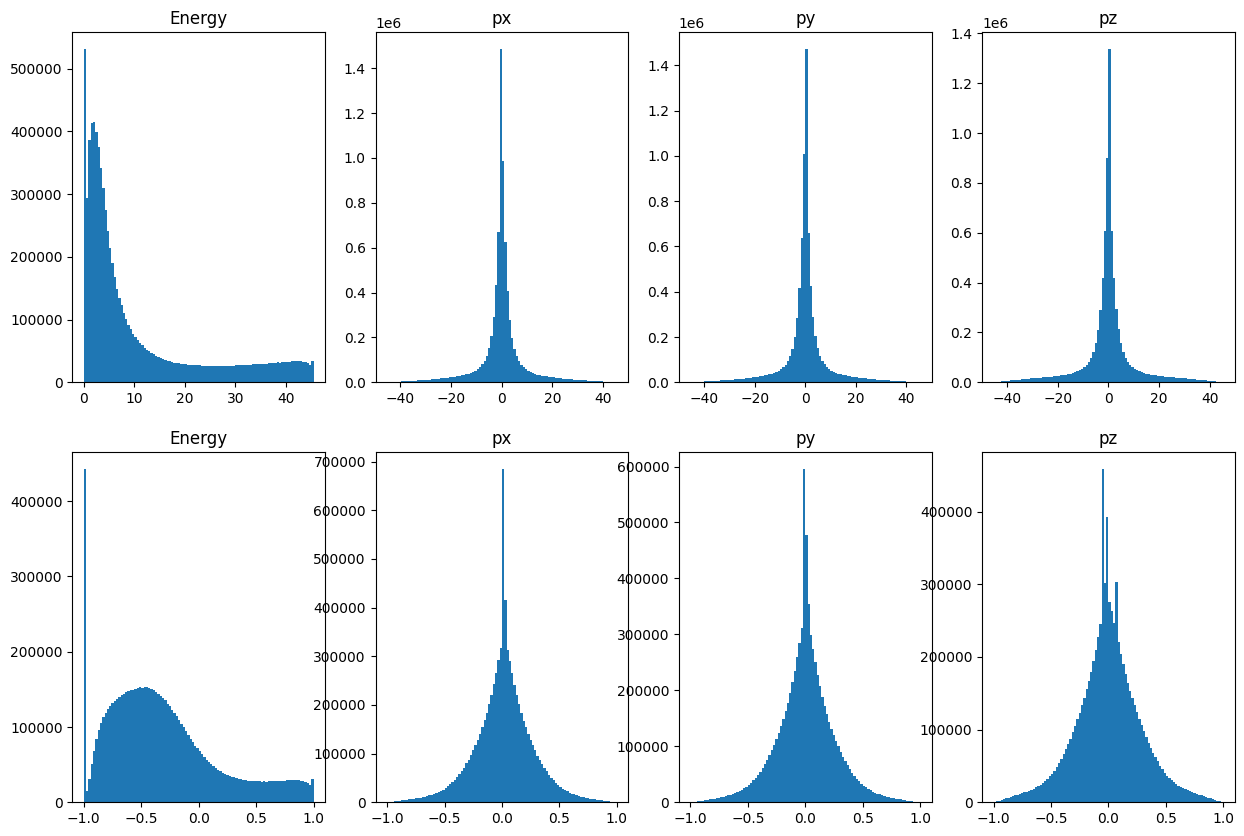

In [3]:
# explore to limits

fig,(ax1,ax2) = plt.subplots(2,4,figsize=(15,10))
ax1[0].hist(events[:,:,0].flatten(),bins=100)
ax1[0].set_title("Energy")
ax1[1].hist(events[:,:,1].flatten(),bins=100)
ax1[1].set_title("px")
ax1[2].hist(events[:,:,2].flatten(),bins=100)
ax1[2].set_title("py")
ax1[3].hist(events[:,:,3].flatten(),bins=100)
ax1[3].set_title("pz")

# normalise all 8 x 3 features with MinMaxScaler
minmax_events = events.copy()
scalers = np.zeros((8,4),dtype=object)
for i in range(8):
    for j in range(4):
        scalers[i,j] = MinMaxScaler((-1,1)).fit(events[:,i,j].reshape(-1,1))
        minmax_events[:,i,j] = scalers[i,j].transform(events[:,i,j].reshape(-1,1)).flatten()

ax2[0].hist(minmax_events[:,:,0].flatten(),bins=100)
ax2[0].set_title("Energy")
ax2[1].hist(minmax_events[:,:,1].flatten(),bins=100)
ax2[1].set_title("px")
ax2[2].hist(minmax_events[:,:,2].flatten(),bins=100)
ax2[2].set_title("py")
ax2[3].hist(minmax_events[:,:,3].flatten(),bins=100)
ax2[3].set_title("pz");

In [4]:
# some parameters
gen_dim = 4
num_hadron = 8
noise_dim = 64
BATCH_SIZE = 8
n_epochs = 100


In [5]:
x_train, x_valid = train_test_split(np.array(minmax_events), test_size=0.99)

# load into tensorflow dataset dtype as float32
pythia_dataset = tf.data.Dataset.from_tensor_slices(x_train.astype(np.float32))
pythia_dataset = pythia_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

print(f"Shape of training images: {x_train.shape}")

Shape of training images: (10000, 8, 4)


2024-07-23 09:29:59.180270: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-23 09:29:59.180310: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-23 09:29:59.180322: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-23 09:29:59.180526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-23 09:29:59.180859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def Generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(64, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(gen_dim*num_hadron, activation='tanh'))
    model.add(tf.keras.layers.Reshape((num_hadron,gen_dim)))
    return model

def Discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(num_hadron,gen_dim)))
    model.add(tf.keras.layers.Dense(128, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(64, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [7]:

generator = Generator()
discriminator = Discriminator()
generator.build((None, noise_dim))
discriminator.build((None, num_hadron, gen_dim))
print(generator.summary())
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 reshape (Reshape)           (None, 8, 4)              0         
                                                                 
Total params: 19712 (77.00 KB)
Trainable params: 19712 (77.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequent

In [8]:
# put them together
def GAN(generator, discriminator):
    model = tf.keras.Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [9]:
gan = GAN(generator, discriminator)

In [10]:
# and run a test using some simple losses
discriminator.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001), loss='binary_crossentropy')
gan.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001), loss='binary_crossentropy')

In [11]:
discriminator_loss = []
gan_loss = []

for i in range(n_epochs):
    for data in pythia_dataset:
        # noise is the input to the generator
        # noise should match the dimension of the data
        #print(BATCH_SIZE, data.shape)
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # the generator creates some fake data
        generated_data = generator(noise)
        # we glue the real and generated data together
        X = tf.concat([data, generated_data], 0)
        # and create the labels 1 for real, 0 for fake
        y = tf.constant([[1.]]*data.shape[0] + [[0.]]*BATCH_SIZE)
        # make sure we update the weights
        discriminator.trainable = True
        # and train
        discriminator.train_on_batch(X, y)
        
        # now we train the GAN
        # first get some noise
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # and make some labels... (should all be signalish so 1)
        y = tf.constant([[1.]]*BATCH_SIZE)
        # don't update the discriminaor weights here
        discriminator.trainable = False
        gan.train_on_batch(noise, y)
    if i % int(n_epochs/10) == 0:
        print(f"Epoch {i}")

2024-07-23 09:30:00.182662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


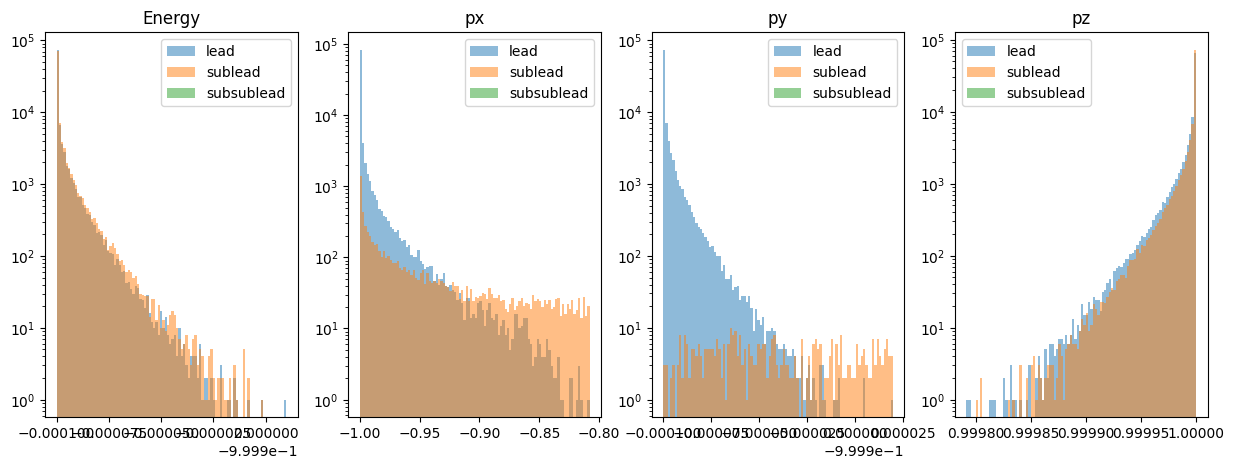

In [12]:
# and inspect the results
noise = tf.random.normal([100000, noise_dim])
generated_data = generator(noise)
# and plot
features = ["Energy","px","py","pz"]
fig,ax = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _,b,_= ax[i].hist(generated_data[:,0,i].numpy().flatten(),bins=100,label="lead",alpha=0.5)
    ax[i].hist(generated_data[:,1,i].numpy().flatten(),bins=b,label="sublead",alpha=0.5)
    ax[i].hist(generated_data[:,2,i].numpy().flatten(),bins=b,label="subsublead",alpha=0.5)
    ax[i].set_title(features[i])
    ax[i].legend()
    ax[i].set_yscale('log')

In [13]:
generated_data = generated_data.numpy()
# scale generated data back to match the original data
for i in range(num_hadron):
    for j in range(gen_dim):
        generated_data[:,i,j] = scalers[i,j].inverse_transform(generated_data[:,i,j].reshape(-1,1)).flatten()

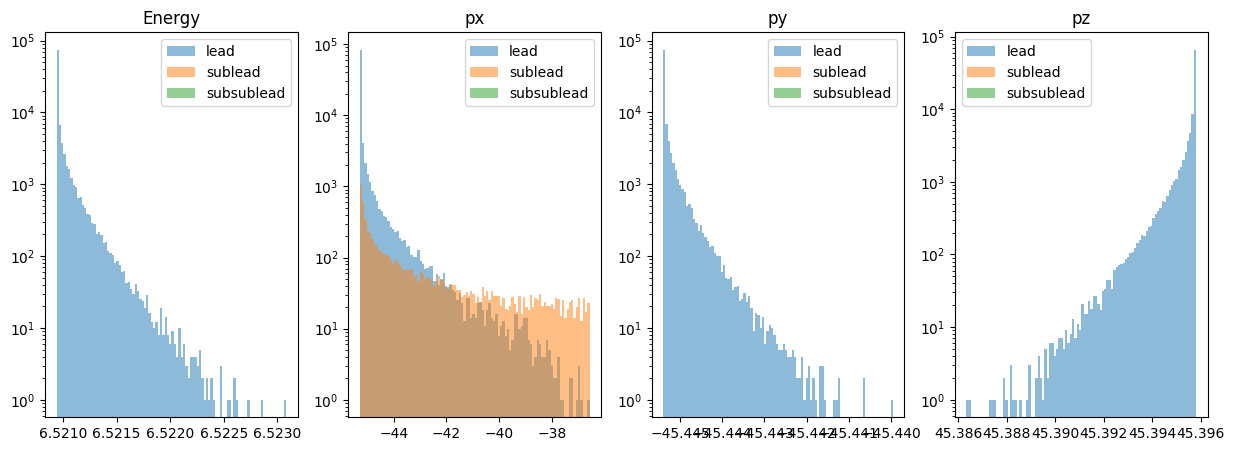

In [14]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _,b,_= ax[i].hist(generated_data[:,0,i],bins=100,label="lead",alpha=0.5)
    ax[i].hist(generated_data[:,1,i],bins=b,label="sublead",alpha=0.5)
    ax[i].hist(generated_data[:,2,i],bins=b,label="subsublead",alpha=0.5)
    ax[i].set_title(features[i])
    ax[i].legend()
    ax[i].set_yscale('log')

/Users/vincentcroft/miniforge3/envs/generator/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


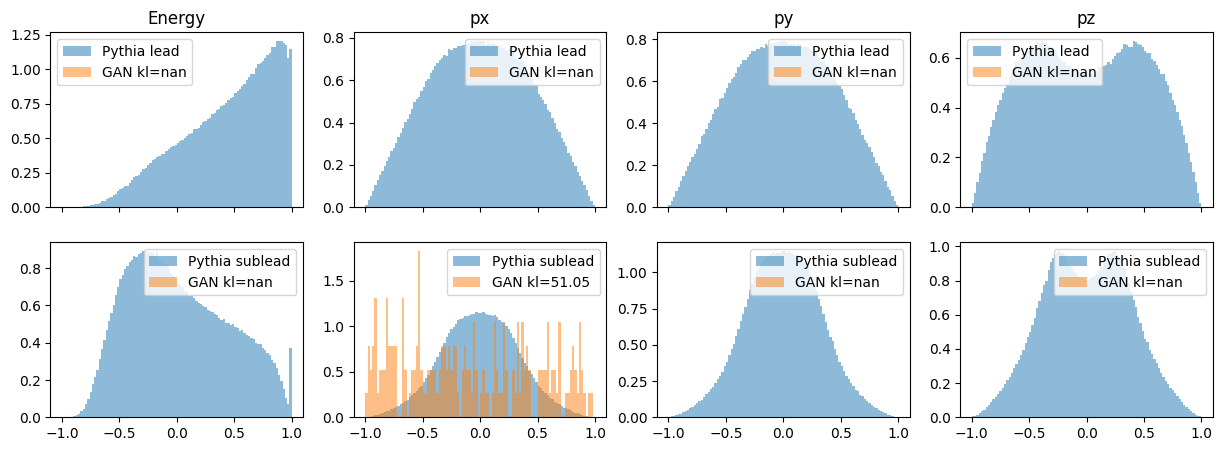

In [15]:
fig,(ax,bx) = plt.subplots(2,4,figsize=(15,5), sharex=True)
for i in range(4):
    pythia_bins,b = np.histogram(x_valid[:,0,i],bins=100,density=True)
    gan_bins,_ = np.histogram(generated_data[:,0,i],bins=b,density=True )
    # calculate KL divergence between GAN and Pythia for this feature
    kl_lead = kl_div(gan_bins,pythia_bins).sum()
    ax[i].hist(x_valid[:,0,i],bins=b,label="Pythia lead",alpha=0.5,density=True)
    ax[i].hist(generated_data[:,0,i],bins=b,label="GAN kl={:.2f}".format(kl_lead),alpha=.5,density=True)
    
    pythia_bins,b = np.histogram(x_valid[:,1,i],bins=100,density=True)
    gan_bins,_ = np.histogram(generated_data[:,1,i],bins=b,density=True)
    kl_sub = kl_div(gan_bins,pythia_bins).sum()
    bx[i].hist(x_valid[:,1,i],bins=b,label="Pythia sublead",alpha=0.5,density=True)
    bx[i].hist(generated_data[:,1,i],bins=b,label="GAN kl={:.2f}".format(kl_sub),alpha=.5,density=True)
    
    ax[i].set_title(features[i])
    ax[i].legend()
    bx[i].legend()


In [16]:
ECM = 91.0

def dot(q1,q2):
    y = q1[1]*q2[1]+q1[2]*q2[2]+q1[3]*q2[3]
    return y

def z_angle(p1,p2):
    if dot(p1,p1)==0.0 or dot(p2,p2) == 0:
        cos_phi = 1.0
    else:
        cos_phi = dot(p1,p2)/(np.sqrt(dot(p1,p1))*np.sqrt(dot(p2,p2)))
    z = (1.0-cos_phi)/2.0    
    return z

def EEC(lst):
    EEC_list = []
    for i in range(lst.shape[0]):
        for j in range(lst.shape[1]):
            for k in range(lst.shape[1]):
                if j!=k:
                    z = z_angle(lst[i,j],lst[i,k])
                    w = lst[i,j,0]*lst[i,k,0]/((ECM**2.0))
                    EEC_list.append((z,w))
    return EEC_list

In [20]:
eec_synthetic = EEC(generated_data)
eec_pythia = EEC(events)

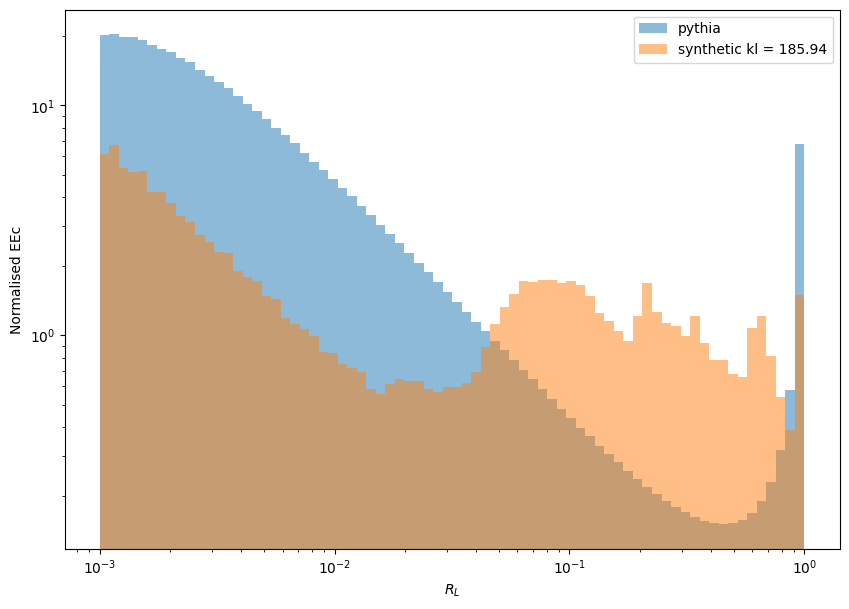

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
# eec are pairs of angles and weights
bins = np.logspace(-3,0,75)

pyt,_,_ = ax.hist([x[0] for x in eec_pythia],bins=bins,weights=[x[1] for x in eec_pythia], alpha=0.5,label="pythia", density=True)
gen,_ = np.histogram([x[0] for x in eec_synthetic],bins=bins,weights=[x[1] for x in eec_synthetic], density=True)
kl_eec = kl_div(gen,pyt).sum()
gen,_,_ = ax.hist([x[0] for x in eec_synthetic],bins=bins,weights=[x[1] for x in eec_synthetic] , alpha=0.5,label="synthetic kl = {:.2f}".format(kl_eec), density=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$R_L$")
ax.set_ylabel("Normalised EEc")
ax.legend();

## Physics inspired scaling

# *TO DO*

Instead of scaling all leading hadrons by the maximum of all leading hadrons and all the subleading by all the subleading we can instead scale each by the energy of the event. This will still give us a number between 0 and 1 (or -1 and 1 with some extra scaling) but now the value of each is actually relevant to the energy correlations of the jet. Here the fact that the different partons belong to different jets means that the average px, py, pz is normally 0... this is a problem since this means that the GAN has to learn these values distributed over the full range of the detector. Not ideal... also then we have to say something about what it means to only take the leading 8 hadrons in an event... I think that if you would like to do this then we can just look at correlations between one parton and another and reduce the dimensionality considerably.

/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_19272/3589107988.py:37: RuntimeWarning: divide by zero encountered in divide
  frac_events[:,i,j] = frac_events[:,i,j]/event_globs[:,j]
/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_19272/3589107988.py:37: RuntimeWarning: invalid value encountered in divide
  frac_events[:,i,j] = frac_events[:,i,j]/event_globs[:,j]


ValueError: supplied range of [-inf, inf] is not finite

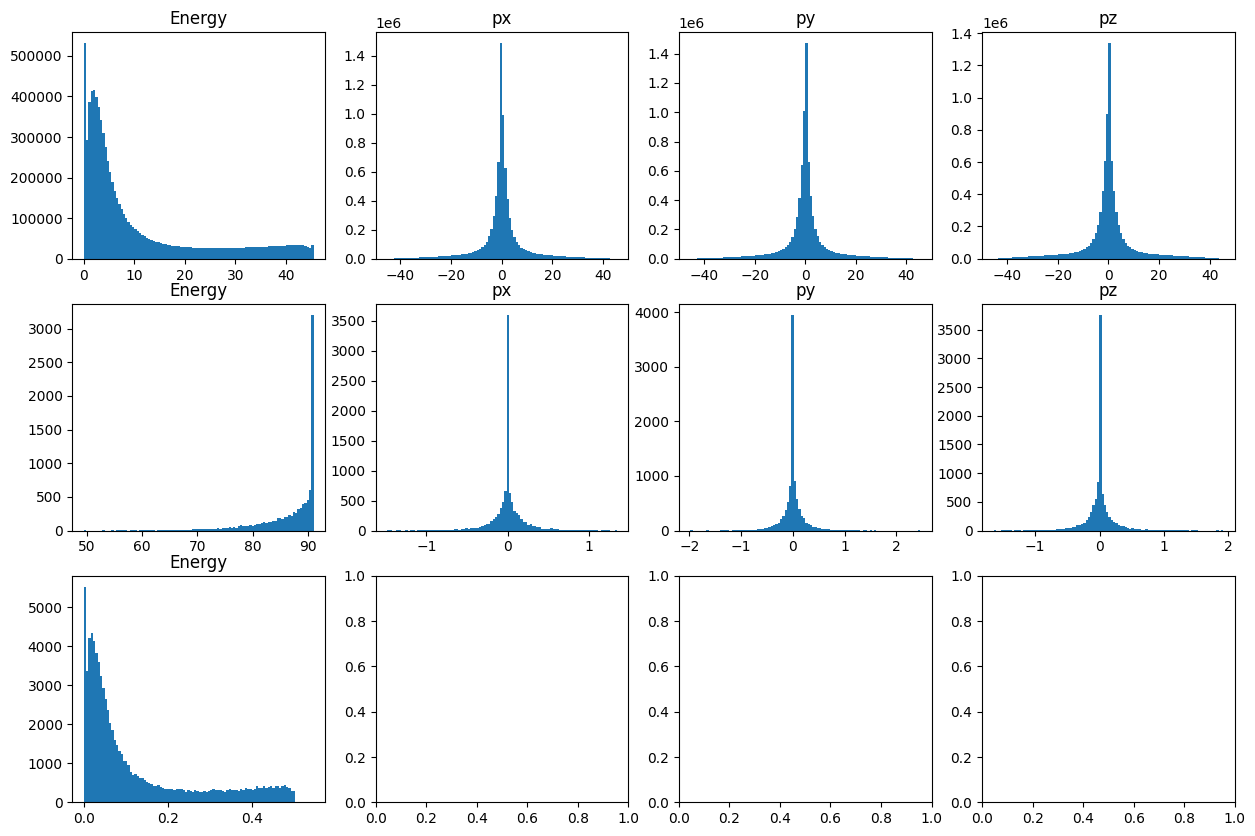

In [28]:
# explore to limits
e = np.loadtxt("./PythiaMomenta.csv",delimiter=",")
e_split = np.split(e,len(e)/8)
events = np.stack(e_split)

fig,(ax1,ax2,ax3) = plt.subplots(3,4,figsize=(15,10))
ax1[0].hist(events[:,:,0].flatten(),bins=100)
ax1[0].set_title("Energy")
ax1[1].hist(events[:,:,1].flatten(),bins=100)
ax1[1].set_title("px")
ax1[2].hist(events[:,:,2].flatten(),bins=100)
ax1[2].set_title("py")
ax1[3].hist(events[:,:,3].flatten(),bins=100)
ax1[3].set_title("pz")

# normalise all hadrons to event level quantities
# not all events
#frac_events = events.copy()
frac_events = events[:10000]
event_globs = np.ones((frac_events.shape[0],frac_events.shape[2]))
# each event will have the total energy, px_tot, py_tot, pz_tot

for i in range(4):
    event_globs[:,i] = np.sum(frac_events[:,:,i],axis=1)

ax2[0].hist(event_globs[:,0],bins=100)
ax2[0].set_title("Energy")
ax2[1].hist(event_globs[:,1],bins=100)
ax2[1].set_title("px")
ax2[2].hist(event_globs[:,2],bins=100)
ax2[2].set_title("py")
ax2[3].hist(event_globs[:,3],bins=100)
ax2[3].set_title("pz");

for i in range(8):
    for j in range(4):
        frac_events[:,i,j] = frac_events[:,i,j]/event_globs[:,j]

ax3[0].hist(frac_events[:,:,0].flatten(),bins=100)
ax3[0].set_title("Energy")
ax3[1].hist(frac_events[:,:,1].flatten(),bins=100)
ax3[1].set_title("px")
ax3[2].hist(frac_events[:,:,2].flatten(),bins=100)
ax3[2].set_title("py")
ax3[3].hist(frac_events[:,:,3].flatten(),bins=100)
ax3[3].set_title("pz");